In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import spacy
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
df = pd.read_csv(r"C:\Users\DeLL\Downloads\Combined Data.csv\Combined Data.csv")

In [3]:
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


### **Dropping unnecessary columns**

In [4]:
df = df.drop(columns=["Unnamed: 0"])

In [5]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


### **Summary of dataframe**

In [6]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


### **Dealing with missing values**

In [8]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().any()

statement    False
status       False
dtype: bool

### **Dealing with Duplicate values**

In [11]:
# total number of duplicate values 

df.duplicated().sum()

np.int64(1588)

In [12]:
df = df.drop_duplicates(subset="statement")

In [13]:
df = df.reset_index(drop=True)

In [14]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [15]:
df.shape

(51073, 2)

### **Inspecting unique classes**

In [16]:
df["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [17]:
#standardizing label names

df["status"] = df["status"].str.strip().str.title()

In [18]:
df["status"].value_counts()

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality Disorder      895
Name: count, dtype: int64

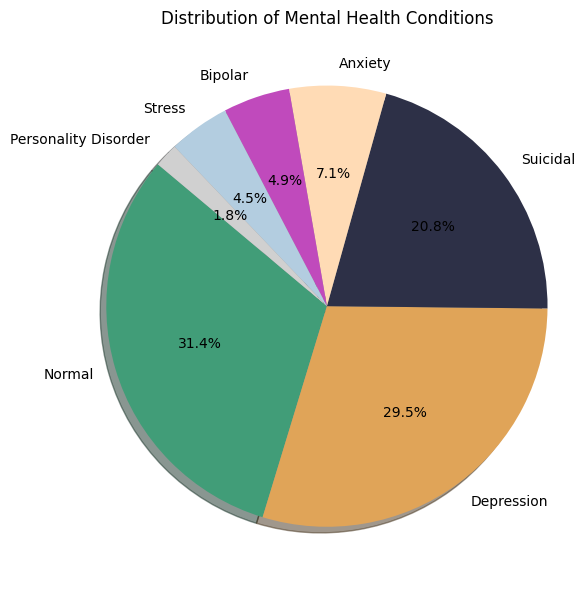

In [19]:
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

### **How long the statements are?**

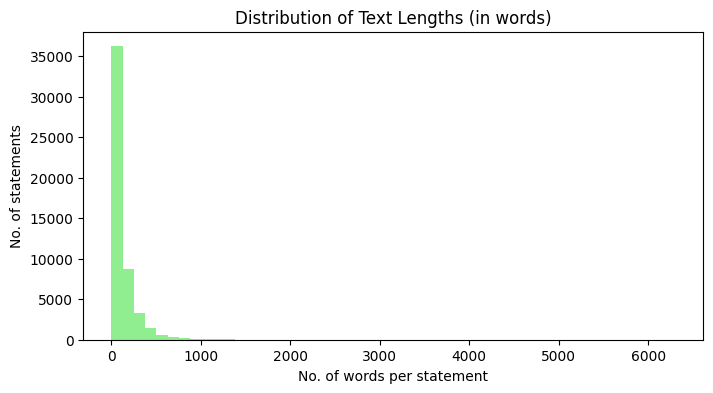

In [20]:
df['text_length'] = df['statement'].apply(lambda x: len(x.split()))

df['text_length'].describe()
plt.figure(figsize=(8,4))
plt.hist(df['text_length'], bins=50, color='lightgreen')
plt.title("Distribution of Text Lengths (in words)")
plt.xlabel("No. of words per statement")
plt.ylabel("No. of statements")
plt.show()

### **Looking at raw texts**

In [23]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Baler question kore rakhce

Status: Bipolar
Statement: Back to the psychiatrist... I sat in the parking lot outside of work today and finally made another appointment with my psychiatrist after three months of quitting medication. I'm so tired of feeling depressed and *angry* and nauseous and paranoid. I'm in a mixed episode and my method of keeping my head down and waiting it out isn't working well for me.

Music sounds strange. Voices and lights are overwhelming. Road rage spills out of me and I'm horrified but unable to stop...and when I'm not behind the wheel my feet drag, I have trouble focusing, every small task a huge ordeal. I haven't cooked in weeks -- I'm either overeating or not eating at all -- and I'm spending way too much money on delivery and drive-thru's. I'm anxious and irritable and bitter and hopeless and yet I know, logically, that I have no reason to feel this way.

I was on medication for six months before I stopped taking everything col

## **TEXT PREPROCESSING**

### basic cleaning

In [24]:
chatwords = {"ain't": "is not","isn t":"is not", "aren't": "are not","can't": "cannot","couldn't": "could not","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hasn't": "has not","haven't": "have not",
              "he's": "he is","she's": "she is","it's": "it is","that's": "that is","there's": "there is","what's": "what is","who's": "who is","I'm": "i am","i'm": "i am",
              "I'll": "i will","i'll": "i will","I'd": "i would","i'd": "i would","I've": "i have","i've": "i have","i ve":"i have", "isn't": "is not","let's": "let us",
              "shouldn't": "should not","won't": "will not","wouldn't": "would not","wasn't": "was not","weren't": "were not","you're": "you are","you've": "you have",
              "you'll": "you will","they're": "they are","they've": "they have","they'll": "they will","we're": "we are","we've": "we have","we'll": "we will","omg": "oh my god",
              "lol": "laughing out loud","lmao": "laughing my ass off","rofl": "rolling on the floor laughing","idk": "i do not know","imo": "in my opinion",
              "imho": "in my humble opinion","btw": "by the way","thx": "thanks","ty": "thank you","pls": "please","plz": "please","u": "you","ur": "your",
              "r": "are","ya": "you","wanna": "want to","gonna": "going to","gotta": "got to","kinda": "kind of","sorta": "sort of","lemme": "let me","gimme": "give me",
              "cuz": "because","bc": "because","bcoz": "because","bcz": "because","b4": "before","gr8": "great","l8r": "later","nvm": "never mind","tho": "though",
              "thx": "thanks","xoxo": "hugs and kisses","tbh": "to be honest","afaik": "as far as i know","asap": "as soon as possible","bff": "best friend forever",
              "brb": "be right back","fyi": "for your information","jk": "just kidding","np": "no problem","sry": "sorry","smh": "shaking my head","ttyl": "talk to you later",
              "wyd": "what are you doing","wtf": "what the fuck","wth": "what the hell","idc": "i do not care","ikr": "i know right","hbu": "how about you","ily": "i love you","luv": "love","n": "and",
              "coz": "because","bday": "birthday","msg": "message"}


In [25]:
def clean_text(text):
    text = text.lower()                                                      #lowercasing
    text = re.sub(r'https?:\/\/\S+', '', text)                               # remove urls
    text = re.sub(r'<.*?>', '', text)                                        # remove html tags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)                               # remove @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)                               # remove hashtags
    text = text.replace('[', '').replace(']', '')                            # removing unnecessary brackets   
   
    text = re.sub(r'\d+', '', text)                                          # remove digits
    text = re.sub(r'\s+', ' ', text).strip()                                 # remove extra spaces
    text = text.replace("’", "'").replace("‘", "'")                          #normalizing apostrophe

    text = " ".join(chatwords.get(word, word) for word in text.split())      # expand chatwords
    text = re.sub(f"[{string.punctuation}]", " ", text)                      #removing punctuation after chatword exp
    
    return text


In [26]:
df["clean_text"] = df["statement"].apply(clean_text)

In [27]:
df.head()

,statement,status,text_length,clean_text
0,oh my gosh,Anxiety,3,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,trouble sleeping confused mind restless hear...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,all wrong back off dear forward doubt stay ...
3,I've shifted my focus to something else but I'...,Anxiety,11,i have shifted my focus to something else but ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,i am restless and restless it is been a month...


In [28]:
df[["statement","clean_text"]].sample(20)

,statement,clean_text
40043,i feel so lonely and empty nothing fill that h...,i feel so lonely and empty nothing fill that h...
49720,Getting used to loneliness I feel like before ...,getting used to loneliness i feel like before ...
5800,grunt,grunt
27302,I was consuming quite a lot of caffeine (up to...,i was consuming quite a lot of caffeine up to...
43975,j xox ohh i hope so not stopin till i get a re...,j xox ohh i hope so not stopin till i get a re...
16848,I just need someone to tell me everything is g...,i just need someone to tell me everything is g...
37518,so i ve been working really hard this last yea...,so i ve been working really hard this last yea...
46126,i think i’m having an episode or some shit the...,i think i am having an episode or some shit th...
6477,How can a person who kills with a smile be cal...,how can a person who kills with a smile be cal...
28253,"Sometimes it goes into an actual panic attack,...",sometimes it goes into an actual panic attack ...


In [29]:
df["statement"][40680]

'post partum depression isn t preached well enough most new mom are not always happy they had the baby'

In [30]:
df["clean_text"][40680]

'post partum depression isn t preached well enough most new mom are not always happy they had the baby'

### lemmatization with spaCy

In [31]:
# !python -m spacy download en_core_web_sm

In [32]:
# !pip install spacy

In [33]:
import spacy

In [34]:
nlp = spacy.load("en_core_web_sm",disable=["ner","parser"])

In [35]:
texts = df["clean_text"].to_list()
docs = nlp.pipe(texts, batch_size=50)

In [36]:
df["lemmatized_text"] = [" ".join([token.lemma_ for token in doc]) for doc in docs]

In [37]:
df.head()

,statement,status,text_length,clean_text,lemmatized_text
0,oh my gosh,Anxiety,3,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,trouble sleeping confused mind restless hear...,trouble sleep confused mind restless heart...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,all wrong back off dear forward doubt stay ...,all wrong back off dear forward doubt st...
3,I've shifted my focus to something else but I'...,Anxiety,11,i have shifted my focus to something else but ...,I have shift my focus to something else but I ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,i am restless and restless it is been a month...,I be restless and restless it be be a month ...


In [38]:
df[["statement","lemmatized_text"]].sample(30)

,statement,lemmatized_text
43749,davidkudrev it s just a pity that facebook cha...,davidkudrev it s just a pity that facebook cha...
415,Nightmares of a few minutes make you anxious a...,nightmare of a few minute make you anxious and...
50573,anxiety around smelling bad it's been 3 days b...,anxiety around smell bad it be be day but I ha...
4283,"I'm lazy, I want to serve your stupid fight, o...",I be lazy I want to serve your stupid fight ...
10926,Just staring at my packed up apartment and fee...,just stare at my pack up apartment and feeling...
10890,"My ex called it small, i cannot work through i...",my ex call it small I can not work through i...
13602,I am tired of people telling me I am attractiv...,I be tired of people tell I I be attractive bu...
9536,The only thing that gives me any hope is that ...,the only thing that give I any hope be that ma...
41032,year ago i wa a grade student this is probably...,year ago I wa a grade student this be probably...
32610,i went to hawaii on vacation.,I go to hawaii on vacation


## **Vectorization & Modelling**

In [39]:
x = df["lemmatized_text"]
y = df["status"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x , y , test_size=0.2 , random_state=42 , stratify=y)

In [41]:
tfidf = TfidfVectorizer(max_features=150000,
                        ngram_range=(1,3),
                        max_df=0.9,
                        min_df=5,
                        sublinear_tf = True)

In [42]:
Xtrain_tfidf = tfidf.fit_transform(X_train)
Xtest_tfidf = tfidf.transform(X_test)

### *LOGISTIC REGRESSION MODEL*

In [43]:
model = LogisticRegression(C=5,
                           max_iter=10000,
                          class_weight="balanced",
                          solver="lbfgs",
                          multi_class = "multinomial")

In [60]:
scores = cross_val_score(model, Xtrain_tfidf, y_train, cv=5, scoring="f1_macro")

C:\Users\DeLL\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\DeLL\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\DeLL\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\DeLL\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\

In [61]:
print("cv scores for each fold",scores)

cv scores for each fold [0.7079683  0.70179846 0.70932887 0.70821525 0.69658264]


In [62]:
print("mean cv score",scores.mean())

mean cv score 0.7047787030639336


In [63]:
print("st deviation",scores.std())

st deviation 0.004873286153054379


So, by looking at the mean we can say that the model gives a very fair and balanced performance and since the standard deviation is quite small which means the model's performance is stable and not overfitting at all.

In [44]:
model.fit(Xtrain_tfidf, y_train)

C:\Users\DeLL\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'multinomial'


In [45]:
ypred = model.predict(Xtest_tfidf)

In [46]:
print(classification_report(y_test, ypred))

                      precision    recall  f1-score   support

             Anxiety       0.78      0.82      0.80       723
             Bipolar       0.76      0.70      0.73       500
          Depression       0.72      0.66      0.69      3018
              Normal       0.90      0.93      0.91      3208
Personality Disorder       0.66      0.49      0.56       179
              Stress       0.53      0.56      0.54       459
            Suicidal       0.65      0.70      0.67      2128

            accuracy                           0.76     10215
           macro avg       0.71      0.69      0.70     10215
        weighted avg       0.76      0.76      0.76     10215



In [47]:
macro_f1 = f1_score(y_test, ypred, average="macro")

In [48]:
macro_f1

0.7017017660796573

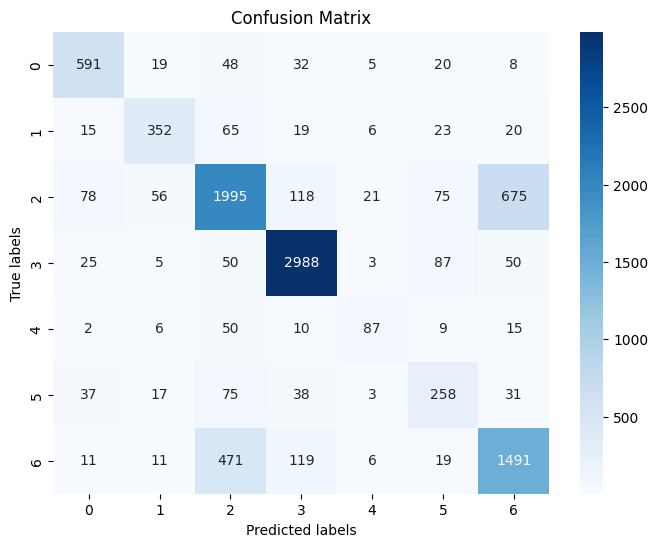

In [49]:
cm = confusion_matrix(y_test, ypred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### *SVM MODEL*

In [50]:
svm = LinearSVC(C=0.1,
               class_weight="balanced",
               max_iter=20000,
               dual=False)

In [51]:
svm.fit(Xtrain_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,0.1
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [52]:
y_pred = svm.predict(Xtest_tfidf)

In [53]:
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

             Anxiety       0.76      0.83      0.79       723
             Bipolar       0.73      0.72      0.73       500
          Depression       0.76      0.63      0.69      3018
              Normal       0.85      0.94      0.90      3208
Personality Disorder       0.60      0.54      0.56       179
              Stress       0.51      0.57      0.54       459
            Suicidal       0.67      0.70      0.68      2128

            accuracy                           0.76     10215
           macro avg       0.70      0.70      0.70     10215
        weighted avg       0.76      0.76      0.75     10215



In [54]:
from sklearn.metrics import f1_score

In [55]:
macro_f1 = f1_score(y_test, y_pred, average="macro")

In [56]:
macro_f1

0.6990051692547992

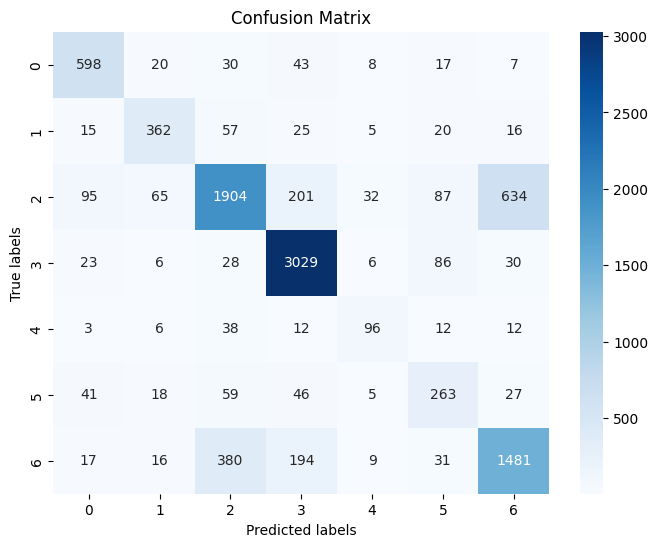

In [57]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()